# Solve minimum fuel landing with NLP solver

In [1]:
import pickle
import cvxpy as cp
import pygmo as pg
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from src.reachsteering import MinFuel
from src.visualization import *
import src.lcvx as lc
%load_ext autoreload
%matplotlib inline

In [2]:
with open('../saved/controllable_set/lander.pkl', 'rb') as f:
        lander = pickle.load(f)

N = 60
tf = 60.0
alt = 1500.0
mass = 1800.0
x0 = np.array([0, 0, alt, -30.0, 0, -55.0, np.log(mass)])

lcvx = lc.LCvxMinFuel(
        rocket=lander,
        N=N,
        parameterize_x0=False,
        parameterize_tf=False,
        fixed_target=False,
    )
prob = lcvx.problem(x0=x0, tf=tf)
prob.solve(solver=cp.ECOS, verbose=False)

281.3120327604892

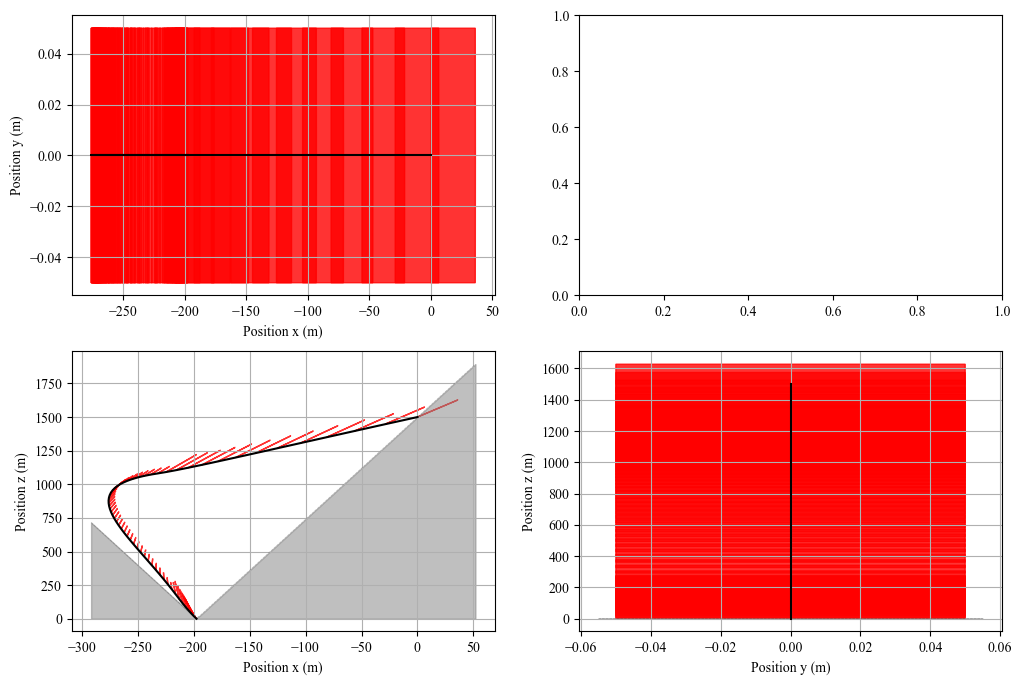

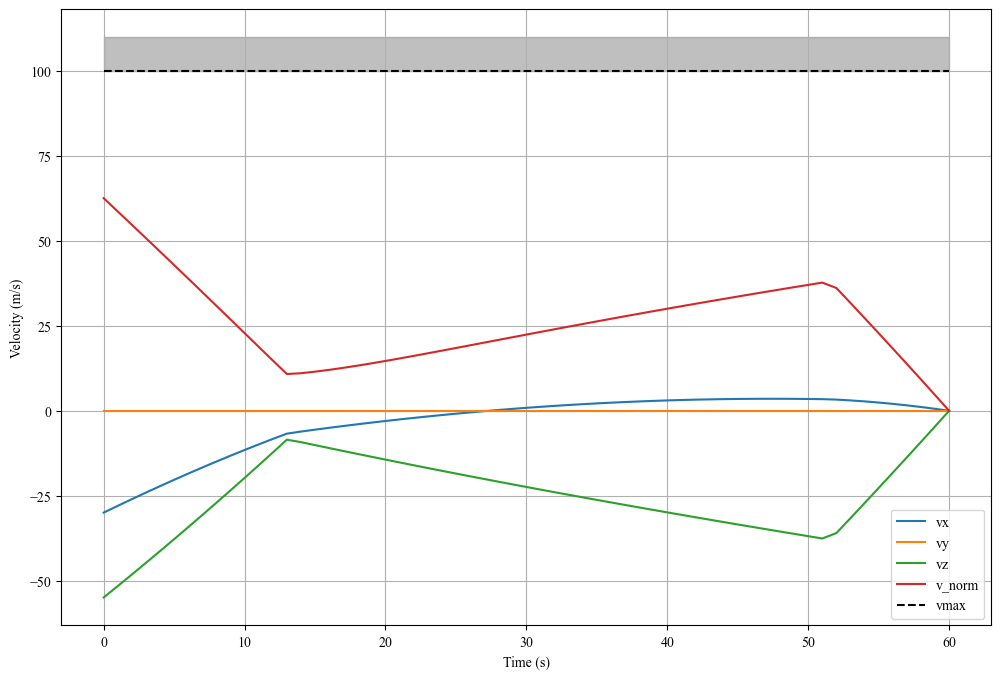

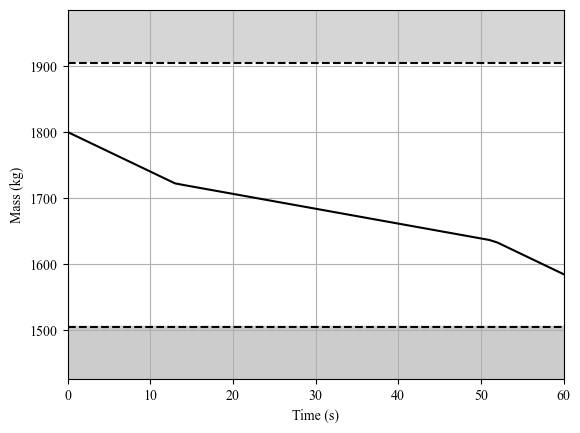

(60,)


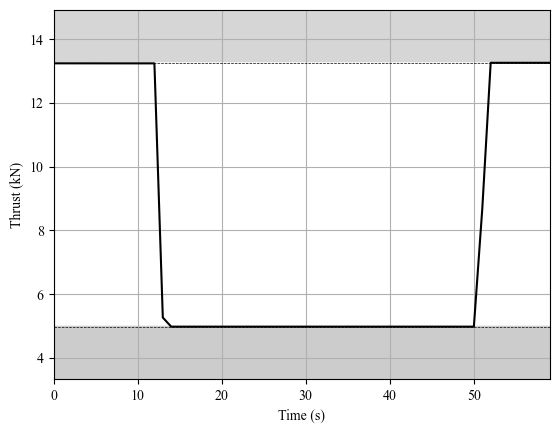

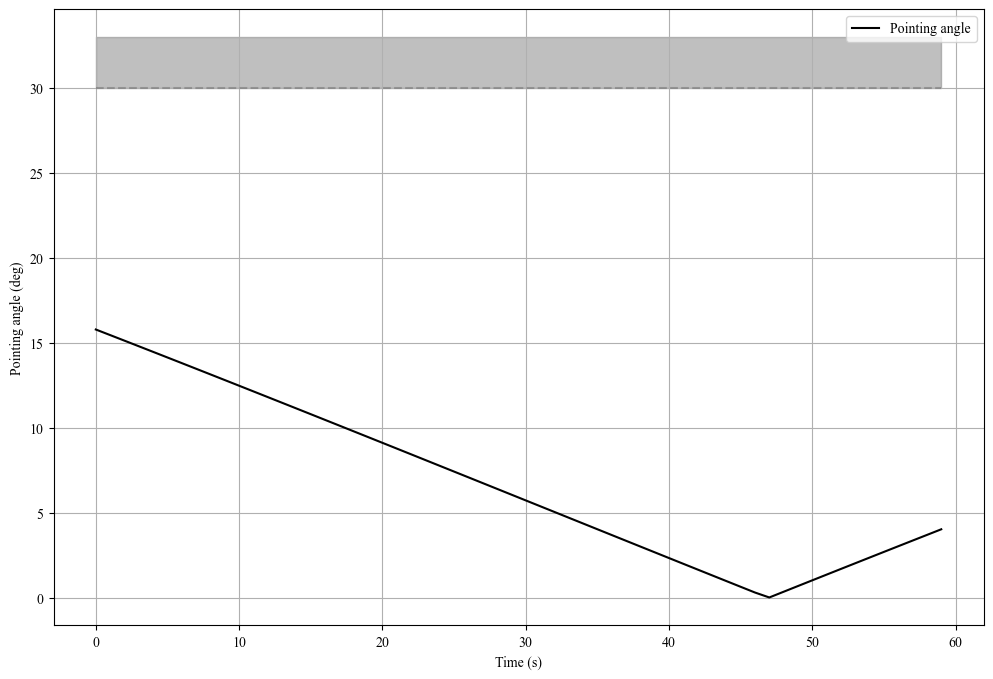

In [3]:
sol = lc.get_vars(prob, ["X", "U"])
X_sol = sol["X"]
U_sol = sol["U"]
r, v, z, u, sigma = lcvx.recover_variables(X_sol, U_sol)
m = np.exp(z)
X = np.hstack((r.T, v.T, m.reshape(-1, 1)))
U = u.T * m[:-1].reshape(-1, 1)
t = np.linspace(0, tf, lcvx.N + 1)

# Plot results
plot_3sides(t[:-1], X, U, uskip=1, gsa=lander.gsa)
plot_vel(t, X, lander.vmax)
plot_mass(t, X, lander.mdry, lander.mwet)
plot_thrust_mag(t[:-1], U, lander.rho2, lander.rho1)
plot_pointing(t[:-1], U, lander.pa)

In [9]:
prob = pg.problem(MinFuel(lander, N, x0, tf, False))
prob.c_tol = [1e-3] * (prob.get_nec() + prob.get_nic())

uda = pg.ipopt()
uda.set_numeric_option("tol", 1e-2)
uda.set_numeric_option("constr_viol_tol", 1e-2)
algo = pg.algorithm(uda)
algo.set_verbosity(1)

print(algo)

Algorithm name: Ipopt: Interior Point Optimization [deterministic]
	C++ class name: class pagmo::ipopt

	Thread safety: none

Extra info:
	Last optimisation return code: Solve_Succeeded (value = 0)
	Verbosity: 1
	Individual selection policy: best
	Individual replacement policy: best
	Numeric options: {constr_viol_tol : 0.01,  tol : 0.01}



In [12]:
pop = pg.population(prob, 0)
u_0 = U.flatten() / lander.rho2
pop.push_back(u_0)
print(f"Feasibility of initial guess: {prob.feasibility_x(u_0)}")

Feasibility of initial guess: False


In [13]:
print(pop)

Problem name: <class 'src.reachsteering.problems.MinFuel'>
	C++ class name: class pybind11::object

	Global dimension:			180
	Integer dimension:			0
	Fitness dimension:			308
	Number of objectives:			1
	Equality constraints dimension:		4
	Inequality constraints dimension:	303
	Tolerances on constraints: [0.001, 0.001, 0.001, 0.001, 0.001, ... ]
	Lower bounds: [-1, -1, -1, -1, -1, ... ]
	Upper bounds: [1, 1, 1, 1, 1, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 55440
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 1
	Gradient evaluations: 0

	Thread safety: none

Population size: 1

List of individuals: 
#0:
	ID:			9433625349399575933
	Decision vector:	[0.271911, 0, 0.960714, 0.266401, 0, ... ]
	Fitness vector:		[215.744, 2.54098e-07, 4.62456e-10, 0, 1.62481e-08, ... ]

Champion decision vector: [0.271911, 0, 0.960714, 0.266401, 0, ... ]
Champion fitness: [215.744, 2

In [ ]:
result = algo.evolve(pop)
print(result)

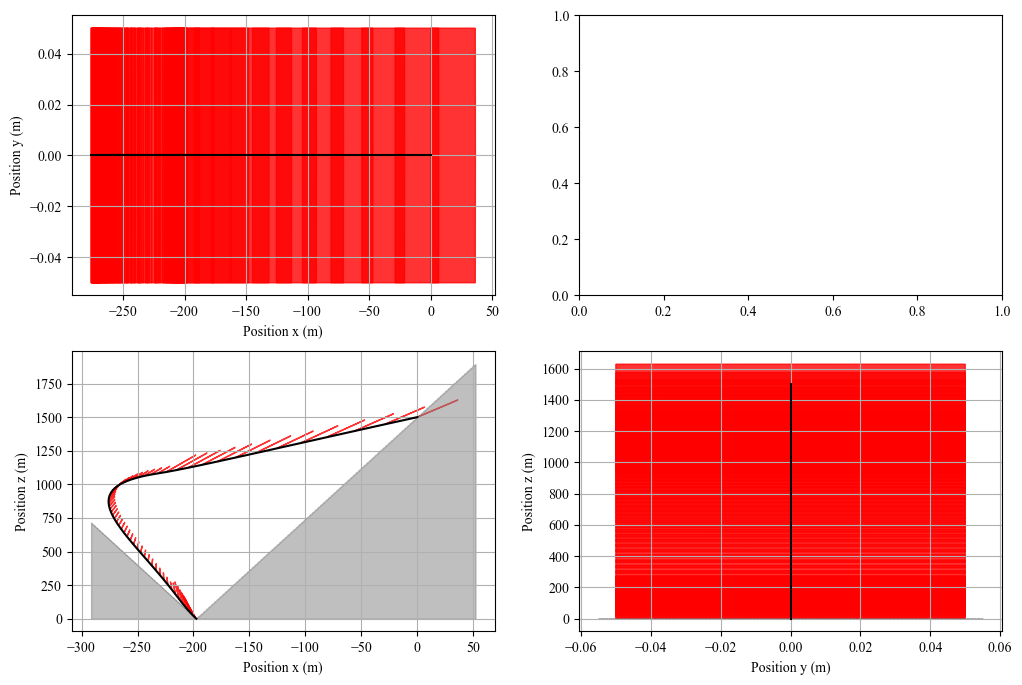

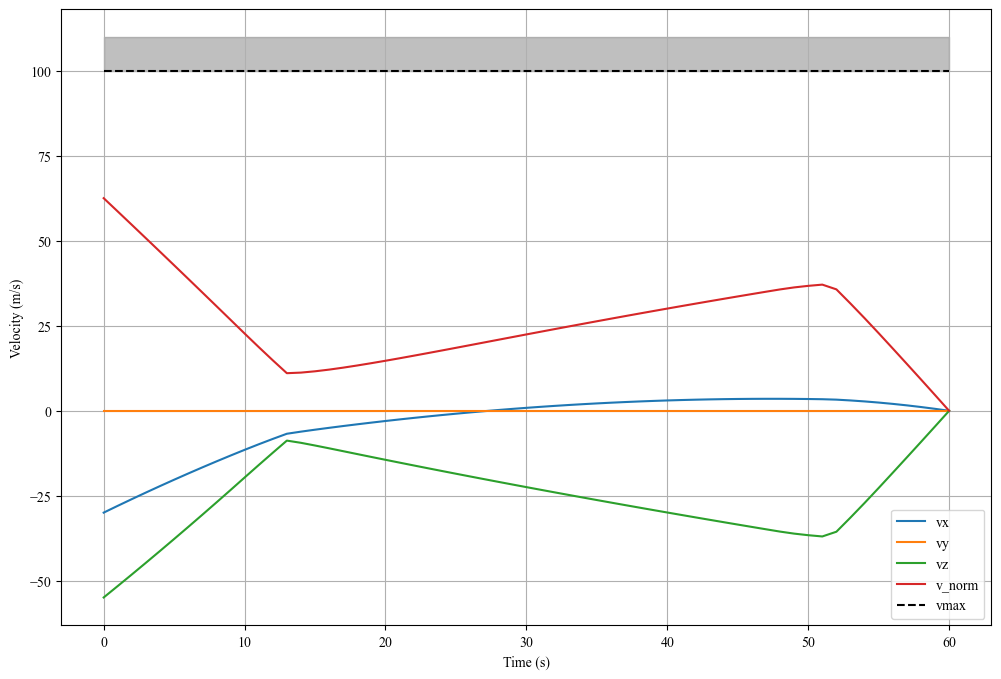

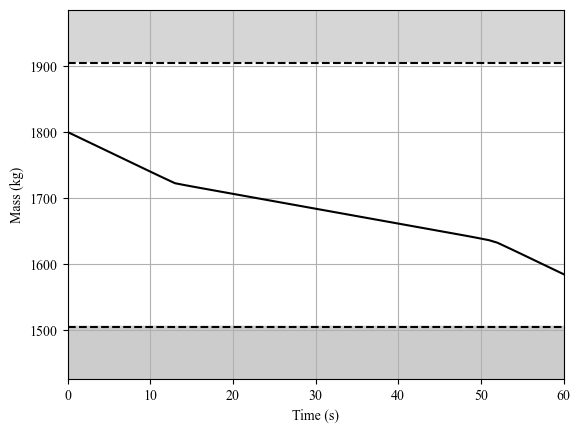

(60,)


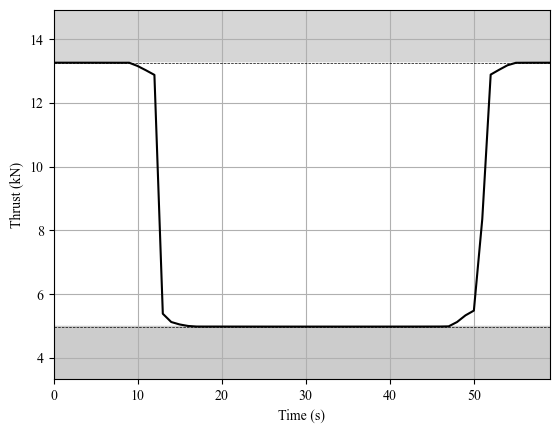

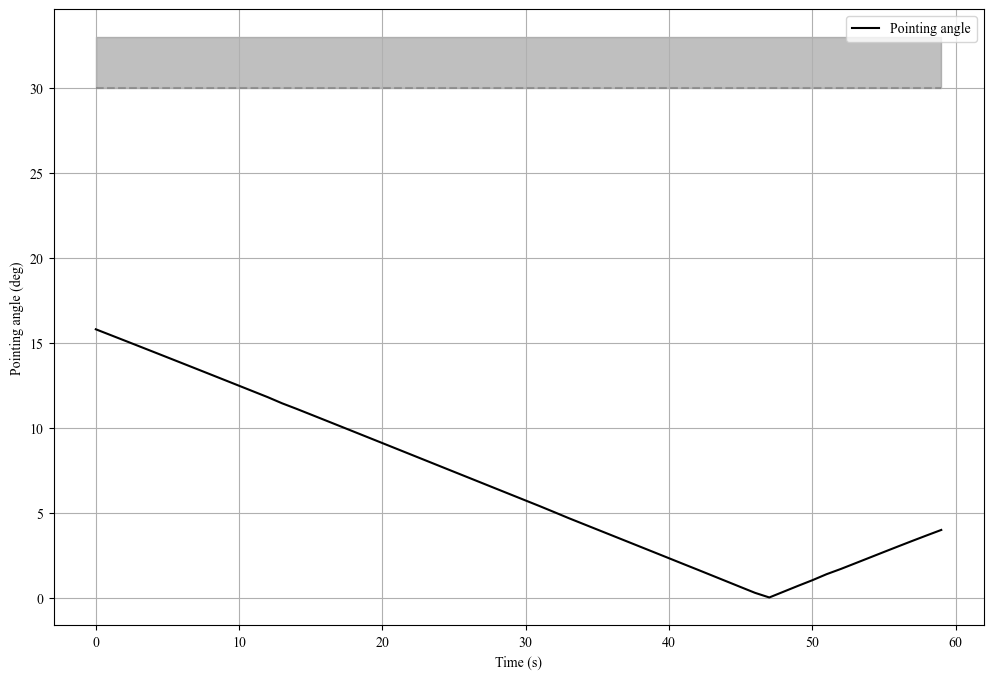

In [15]:
U = result.champion_x.reshape(-1, 3) * lander.rho2
r, v, z = np.zeros((N + 1, 3)), np.zeros((N + 1, 3)), np.zeros(N + 1)
r[0] = x0[:3]
v[0] = x0[3:6]
z[0] = x0[6]
from src.reachsteering.problems import _dynamics
for i in range(N):
    
    r[i + 1], v[i + 1], z[i + 1] = _dynamics(r[i], v[i], z[i], U[i], tf/N, lander.g, lander.alpha)

X = np.hstack((r, v, np.exp(z).reshape(-1, 1)))
# Plot results
plot_3sides(t[:-1], X, U, uskip=1, gsa=lander.gsa)

plot_vel(t, X, lander.vmax)

plot_mass(t, X, lander.mdry, lander.mwet)

plot_thrust_mag(t[:-1], U, lander.rho2, lander.rho1)

plot_pointing(t[:-1], U, lander.pa)


In [16]:
result

Problem name: <class 'src.reachsteering.problems.MinFuel'>
	C++ class name: class pybind11::object

	Global dimension:			180
	Integer dimension:			0
	Fitness dimension:			308
	Number of objectives:			1
	Equality constraints dimension:		4
	Inequality constraints dimension:	303
	Tolerances on constraints: [0, 0, 0, 0, 0, ... ]
	Lower bounds: [-1, -1, -1, -1, -1, ... ]
	Upper bounds: [1, 1, 1, 1, 1, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 55440
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 6669
	Gradient evaluations: 1188

	Thread safety: none

Population size: 1

List of individuals: 
#0:
	ID:			15468911319151960235
	Decision vector:	[0.272546, 0, 0.962143, 0.267021, 0, ... ]
	Fitness vector:		[215.743, -4.01279e-12, -5.55112e-16, 0, -3.39284e-13, ... ]

Champion decision vector: [0.272546, 0, 0.962143, 0.267021, 0, ... ]
Champion fitness: [215.743, -4.01279e-1